In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

from going_modular import data_setup, engine

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
target_file = Path("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip").name
target_file

'pizza_steak_sushi.zip'

In [6]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7a510bf8bed0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7a51085aa690>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [9]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [10]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

DataLoader will reseed workers following Randomness in multi-process data loading algorithm. Use worker_init_fn() and generator to preserve reproducibility:
reference:https://pytorch.org/docs/stable/notes/randomness.html
https://pytorch.org/docs/stable/data.html#data-loading-randomness

In [14]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9131 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8975 | train_acc: 0.6562 | test_loss: 0.7837 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8038 | train_acc: 0.7461 | test_loss: 0.6722 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6770 | train_acc: 0.8516 | test_loss: 0.6698 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7065 | train_acc: 0.7188 | test_loss: 0.6745 | test_acc: 0.7737


In [15]:
# Check out the model results
results

{'train_loss': [1.0924372971057892,
  0.8974919840693474,
  0.8037929087877274,
  0.6770033612847328,
  0.7065391577780247],
 'train_acc': [0.3984375, 0.65625, 0.74609375, 0.8515625, 0.71875],
 'test_loss': [0.9131428996721903,
  0.7836780746777853,
  0.672193189462026,
  0.6697825988133749,
  0.6745174924532572],
 'test_acc': [0.5397727272727273,
  0.8560606060606061,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

In [16]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%load_ext tensorboard
%tensorboard --logdir runs

In [17]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [18]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_10_percent/effnetb0/5_epochs...


In [19]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [20]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [21]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [22]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [23]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [24]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [25]:
# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [26]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [27]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [29]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [30]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7175 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7075 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7175 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5611 | train_acc: 0.8984 | test_loss: 0.5949 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5567 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4702 | train_acc: 0.9492 | test_loss: 0.5177 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5728 | train_acc: 0.7773 | test_loss: 0.5095 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4795 | train_acc: 0.8242 | test_loss: 0.4640 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7075 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6126 | train_acc: 0.8008 | test_loss: 0.6403 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6199 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6226 | test_acc: 0.8466
Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4460 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3909 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7767 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4462 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4460 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3909 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3568 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3550 | train_acc: 0.9250 | test_loss: 0.3186 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3350 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3094 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3620 | train_acc: 0.8479 | test_loss: 0.2781 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7767 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4462 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4554 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4228 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8771 | test_loss: 0.4344 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3308 | train_acc: 0.8979 | test_loss: 0.4241 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3906 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [31]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8134), started 0:01:25 ago. (Use '!kill 8134' to kill it.)

In [32]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [33]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


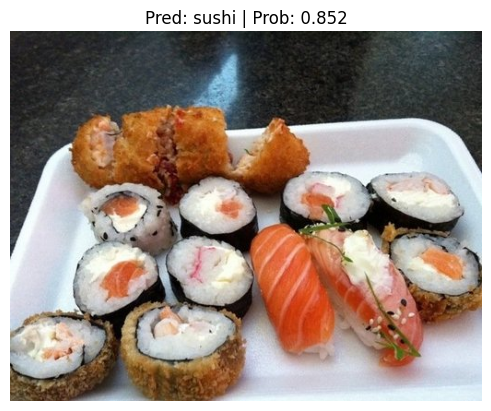

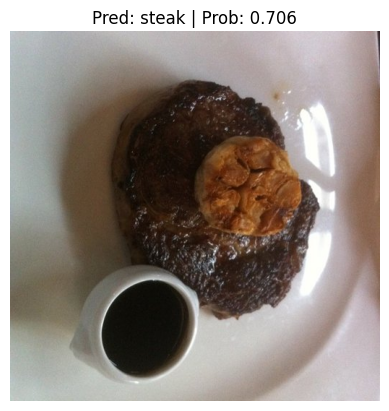

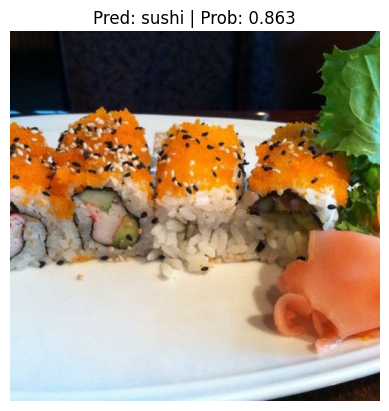

In [34]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

data/04-pizza-dad.jpeg already exists, skipping download.


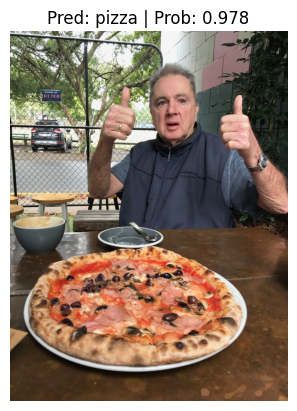

In [35]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)

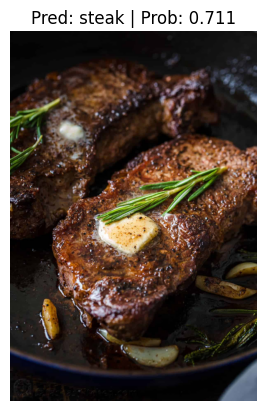

In [36]:
custom_image_path = Path("data/steak.jpeg")

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)

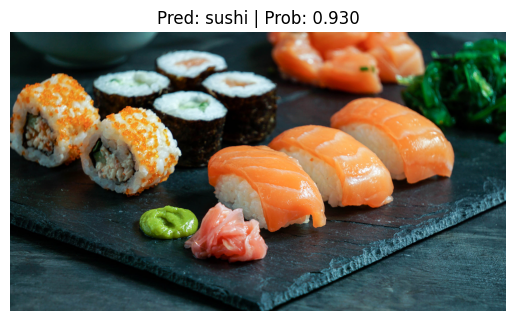

In [37]:
custom_image_path = Path("data/sushi.jpeg")

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)

exercise:
1.Pick a larger model from torchvision.models to add to the list of experiments (for example, EffNetB3 or higher).
How does it perform compared to our existing models?

In [38]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB7 with pretrained weights
effnetb7_weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb7 = torchvision.models.efficientnet_b7(weights=effnetb7_weights)

# # 2. Get a summary of standard EffNetB7 from torchvision.models (uncomment for full output)
summary(model=effnetb7, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 2560, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 64, 112, 112]   1,728                True
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    │    └─SiLU (2)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 64, 112, 112]   [32, 32, 112

In [39]:
# 3. Get the number of in_features of the EfficientNetB7 classifier layer
print(f"Number of in_features to final layer of EfficientNetB7: {len(effnetb7.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB7: 2560


In [40]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB7 feature extractor
def create_effnetb7():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
    model = torchvision.models.efficientnet_b7(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features=2560, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb7"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [41]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

model7 = create_effnetb7() # creates a new model
NUMBER_EPOCHS = 10
model_name = "effnetb7"
dataloader_name = "data_20_percent"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model7.parameters(), lr=0.001)

train(model=model7,
        train_dataloader=train_dataloader_20_percent,
        test_dataloader=test_dataloader, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUMBER_EPOCHS,
        device=device,
        writer=create_writer(experiment_name=dataloader_name,
                                model_name=model_name,
                                extra=f"{NUMBER_EPOCHS}_epochs"))
            
        # 1Save the model to file so we can get back the best model
save_filepath = f"07_{model_name}_{dataloader_name}_{NUMBER_EPOCHS}_epochs.pth"
save_model(model=model7,
            target_dir="models",
            model_name=save_filepath)
print("-"*50 + "\n")

[INFO] Created new effnetb7 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_20_percent/effnetb7/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9777 | train_acc: 0.6104 | test_loss: 0.8926 | test_acc: 0.7131
Epoch: 2 | train_loss: 0.7563 | train_acc: 0.8167 | test_loss: 0.7275 | test_acc: 0.8466
Epoch: 3 | train_loss: 0.6338 | train_acc: 0.8792 | test_loss: 0.6203 | test_acc: 0.8570
Epoch: 4 | train_loss: 0.5620 | train_acc: 0.8521 | test_loss: 0.5554 | test_acc: 0.8674
Epoch: 5 | train_loss: 0.4984 | train_acc: 0.8938 | test_loss: 0.5142 | test_acc: 0.8371
Epoch: 6 | train_loss: 0.4773 | train_acc: 0.8875 | test_loss: 0.4865 | test_acc: 0.8267
Epoch: 7 | train_loss: 0.4323 | train_acc: 0.8979 | test_loss: 0.4706 | test_acc: 0.8163
Epoch: 8 | train_loss: 0.4198 | train_acc: 0.8875 | test_loss: 0.4637 | test_acc: 0.8466
Epoch: 9 | train_loss: 0.3861 | train_acc: 0.9083 | test_loss: 0.4594 | test_acc: 0.8362
Epoch: 10 | train_loss: 0.3883 | train_acc: 0.8938 | test_loss: 0.4516 | test_acc: 0.8362
[INFO] Saving model to: models/07_effnetb7_data_20_percent_10_epochs.pth
------------------------------------

In [42]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8134), started 0:02:04 ago. (Use '!kill 8134' to kill it.)

2.Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
For example, you could have one training DataLoader that uses data augmentation (e.g. train_dataloader_20_percent_aug and train_dataloader_20_percent_no_aug) and then compare the results of two of the same model types training on these two DataLoaders.

In [43]:
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Helper function to view images in a DataLoader (works with data augmentation transforms or not) 
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [44]:
train_dataloader_aug_20_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    train_transform=train_transform_data_aug,
    test_transform=simple_transform,
    batch_size=BATCH_SIZE
)

In [45]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

model7 = create_effnetb7() # creates a new model
NUMBER_EPOCHS = 10
model_name = "effnetb7"
dataloader_name = "data_aug_20_percent"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model7.parameters(), lr=0.001)

train(model=model7,
        train_dataloader=train_dataloader_aug_20_percent,
        test_dataloader=test_dataloader, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUMBER_EPOCHS,
        device=device,
        writer=create_writer(experiment_name=dataloader_name,
                                model_name=model_name,
                                extra=f"{NUMBER_EPOCHS}_epochs"))
            
        # 1Save the model to file so we can get back the best model
save_filepath = f"07_{model_name}_{dataloader_name}_{NUMBER_EPOCHS}_epochs.pth"
save_model(model=model7,
            target_dir="models",
            model_name=save_filepath)
print("-"*50 + "\n")

[INFO] Created new effnetb7 model.
[INFO] Created SummaryWriter, saving to: runs/2024-03-22/data_aug_20_percent/effnetb7/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0018 | train_acc: 0.5813 | test_loss: 0.8800 | test_acc: 0.8030
Epoch: 2 | train_loss: 0.8218 | train_acc: 0.7292 | test_loss: 0.7258 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.6832 | train_acc: 0.8333 | test_loss: 0.6019 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6590 | train_acc: 0.8125 | test_loss: 0.5168 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.5948 | train_acc: 0.8229 | test_loss: 0.4789 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5844 | train_acc: 0.8187 | test_loss: 0.4194 | test_acc: 0.9062
Epoch: 7 | train_loss: 0.5374 | train_acc: 0.8313 | test_loss: 0.4261 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5208 | train_acc: 0.7979 | test_loss: 0.4170 | test_acc: 0.8456
Epoch: 9 | train_loss: 0.5098 | train_acc: 0.8167 | test_loss: 0.3738 | test_acc: 0.8655
Epoch: 10 | train_loss: 0.4581 | train_acc: 0.8542 | test_loss: 0.3937 | test_acc: 0.8456
[INFO] Saving model to: models/07_effnetb7_data_aug_20_percent_10_epochs.pth
--------------------------------

3.Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire Food101 dataset from torchvision.models
You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
If you try more than one model, it would be good to have the model's results tracked.
If you load the Food101 dataset from torchvision.models, you'll have to create PyTorch DataLoaders to use it in training.
Note: Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

In [46]:
from pathlib import Path
# Setup directories
data_path = Path("data/")
image_path = data_path / "food-101_100_percent"
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7a50cbf1ea10>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'ho

In [47]:
import torchvision
# Create model
effnetb7_weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
foodvision_big_model = torchvision.models.efficientnet_b7(weights=effnetb7_weights).to(device)

# Freeze the base layers
for param in foodvision_big_model.features.parameters():
  param.requires_grad = False

# Change the classifier head to suit 101 different classes
foodvision_big_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2560, out_features=101) # 101 output classes for Food101 
).to(device)

summary(model=foodvision_big_model,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 101]                  --
├─Sequential: 1-1                                       [1, 2560, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 112, 112]         (1,728)
│    │    └─BatchNorm2d: 3-2                            [1, 64, 112, 112]         (128)
│    │    └─SiLU: 3-3                                   [1, 64, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112]         (4,944)
│    │    └─MBConv: 3-5                                 [1, 32, 112, 112]         (1,992)
│    │    └─MBConv: 3-6                                 [1, 32, 112, 112]         (1,992)
│    │    └─MBConv: 3-7              

In [48]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

NUMBER_EPOCHS = 5
model_name = "effnetb7"
dataloader_name = "food-101_100_percent"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=foodvision_big_model.parameters(), lr=0.001)

train(model=foodvision_big_model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUMBER_EPOCHS,
        device=device,
        writer=create_writer(experiment_name=dataloader_name,
                                model_name=model_name,
                                extra=f"{NUMBER_EPOCHS}_epochs"))
            
        # 1Save the model to file so we can get back the best model
save_filepath = f"07_{model_name}_{dataloader_name}_{NUMBER_EPOCHS}_epochs.pth"
save_model(model=model7,
            target_dir="models",
            model_name=save_filepath)
print("-"*50 + "\n")

[INFO] Created SummaryWriter, saving to: runs/2024-03-22/food-101_100_percent/effnetb7/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1533 | train_acc: 0.2966 | test_loss: 2.3972 | test_acc: 0.4371
Epoch: 2 | train_loss: 2.6801 | train_acc: 0.3685 | test_loss: 2.2543 | test_acc: 0.4537
Epoch: 3 | train_loss: 2.6197 | train_acc: 0.3801 | test_loss: 2.2073 | test_acc: 0.4635
Epoch: 4 | train_loss: 2.5953 | train_acc: 0.3861 | test_loss: 2.1728 | test_acc: 0.4677
Epoch: 5 | train_loss: 2.5887 | train_acc: 0.3900 | test_loss: 2.1551 | test_acc: 0.4702
[INFO] Saving model to: models/07_effnetb7_food-101_100_percent_5_epochs.pth
--------------------------------------------------

CPU times: user 10min 25s, sys: 1min 54s, total: 12min 20s
Wall time: 11min 33s


In [49]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8134), started 0:16:21 ago. (Use '!kill 8134' to kill it.)